## Import necessary modules

In [1]:
# make sure jupyter path is correct for loading local moudules
import sys
# path to steric_simulator module relative to notebook
sys.path.append("../../../")
import copy
from KineticAssembly_AD import ReactionNetwork, VectorizedRxnNet, VecSim, Optimizer, EquilibriumSolver
import networkx as nx
import torch
from torch import DoubleTensor as Tensor

## Setup Reaction Network
#### Read the corresponding input file and call the ReactionNetwork class

In [2]:
base_input = '../input_files/trimer.pwr'
rn = ReactionNetwork(base_input, one_step=True)
rn.resolve_tree()

['default_assoc', 1.0]
New node added - Node index: 3 ; Node label: AB 
New node added - Node index: 4 ; Node label: AC 
Trying internal bonds
New node added - Node index: 5 ; Node label: BC 
New node added - Node index: 6 ; Node label: ABC 
Trying internal bonds
Trying internal bonds
Trying internal bonds
Trying internal bonds
Trying internal bonds
Trying internal bonds
Reaction Network Completed


In [3]:
uid_dict = {}
sys.path.append("../../")
import numpy as np
from reaction_network import gtostr
for n in rn.network.nodes():
    #print(n)
    #print(rn.network.nodes()[n])
    for k,v in rn.network[n].items():
        uid = v['uid']
        r1 = set(gtostr(rn.network.nodes[n]['struct']))
        p = set(gtostr(rn.network.nodes[k]['struct']))
        r2 = p-r1
        reactants = (r1,r2)
        uid_dict[(n,k)] = uid

print(uid_dict)

{(0, 3): 0, (0, 4): 1, (0, 6): 5, (1, 3): 0, (1, 5): 2, (1, 6): 3, (2, 4): 1, (2, 5): 2, (2, 6): 4, (3, 6): 4, (4, 6): 3, (5, 6): 5}


## Set Initial conditions for the association rates
This can be done from the user_input file, but currently the code only allows 1 value to be read (from default_assoc parameter).
To set starting rates to different values this code block takes in a list/array of all rxn rates and updates them in the reaction network object.

In [4]:
new_kon = torch.zeros([rn._rxn_count], requires_grad=True).double()

new_kon = [5,5,5,5,5,5]

update_kon_dict = {}
for edge in rn.network.edges:
    print(rn.network.get_edge_data(edge[0],edge[1]))
    update_kon_dict[edge] = new_kon[uid_dict[edge]]

nx.set_edge_attributes(rn.network,update_kon_dict,'k_on')
for edge in rn.network.edges:
    print(rn.network.get_edge_data(edge[0],edge[1]))

{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-8.], dtype=torch.float64), 'uid': 0}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-8.], dtype=torch.float64), 'uid': 1}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-16.], dtype=torch.float64), 'uid': 5}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-8.], dtype=torch.float64), 'uid': 0}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-8.], dtype=torch.float64), 'uid': 2}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-16.], dtype=torch.float64), 'uid': 3}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-8.], dtype=torch.float64), 'uid': 1}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-8.], dtype=torch.float64), 'uid': 2}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-16.], dtype=torch.float64), 'uid': 4}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-16.], dtype=torch.float64), 'uid': 4}
{'k_on': 1.0, 'k

## Define the VectorizedRxnNet class
This takes the corresponding rxn network class as input and creates tensor arrays for all parameters values required for running a simulation.

In [5]:
vec_rn = VectorizedRxnNet(rn, dev='cpu')
vec_rn.reset()
# print(vec_rn.kon)


Reaction rates:  tensor([5., 5., 5., 5., 5., 5.], dtype=torch.float64, grad_fn=<CopySlices>)
dGs:  tensor([ -8.,  -8.,  -8., -16., -16., -16.], dtype=torch.float64)
Species Concentrations:  tensor([100., 100., 100.,   0.,   0.,   0.,   0.], dtype=torch.float64)
Shifting to device:  cpu


## Create the VecSim class to run a simulation
Takes the VecRxnNEt  object as input. The simulation runtime is set by the 'runtime' argument. (Units - sec)

In [6]:
runtime = 0.2
sim = VecSim(vec_rn, runtime, device='cpu')


Using CPU


# Run a Simulation
### Input Parameters: 
conc_scale: Controls the conc step at each iteration. Since the numerical integration is not performed over fixed time steps but over fixed conc. steps. For e.g. for a value of 1uM, at each iteration step a total of app. 1uM is reacted (includes all species). Can be run using the default value. A general rule is use conc_scale = 0.01 * Max_yield

conc_thresh:This can be used to periodically decrease the conc_scale parameter. After each iteration if the conc_scale is greater than the conc_thresh, then the conc_scale is decreased by mod_factor.Can be run using the default value. 

mod_bool: This argument is necessary to fix the mass balance criteria. Sometimes if the conc_scale is large, then the simulation can lead to a higher consumption of a particular species which is very low in conc, and create more of this species out of nothing. Default value:True

verbose : Print output and progress of simulation

yield_species : The species whose yield is to be tracked and returned to the optimzer. 



In [7]:
y = sim.simulate(conc_scale=1e-1,conc_thresh=1e-2,mod_bool=True,verbose=True,yield_species=6)

Start of simulation: memory Used:  85.3
Simulation rates:  tensor([5.0000e+00, 5.0000e+00, 5.0000e+00, 5.0000e+00, 5.0000e+00, 5.0000e+00,
        1.6773e+03, 1.6773e+03, 1.6773e+03, 5.6268e-01, 5.6268e-01, 5.6268e-01],
       dtype=torch.float64, grad_fn=<ExpBackward>)
Memory Used: 84.8
RAM Usage (GB): 11.740333557128906
Current Time: tensor(0.0152, dtype=torch.float64, grad_fn=<AddBackward0>)
Memory Used: 86.7
RAM Usage (GB): 12.009040832519531
Current Time: tensor(0.0952, dtype=torch.float64, grad_fn=<AddBackward0>)
Final Conc Scale:  0.1
Number of steps:  27452
Next time larger than simulation runtime. Ending simulation.
Memory Used:  86.3
RAM Usage (GB):  11.946624755859375
Final Yield:  tensor(0.8393, dtype=torch.float64, grad_fn=<DivBackward0>)


In [8]:
print("Done")
# print(sim.observables[-1][1])

Done


## Plot the conc. of all species vs time

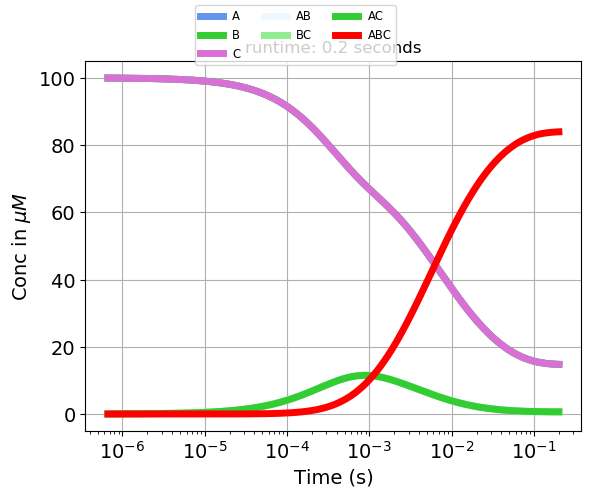

In [9]:
from matplotlib import pyplot as plt
%matplotlib inline
fig, ax = plt.subplots()
nodes_list = ['A','B','C','AB','BC','AC','ABC']
sim.plot_observable(nodes_list, ax=ax,legend=False,seed=201,lw=5)
ax.set_title("runtime: " + str(runtime) + " seconds")
handles,labels = ax.get_legend_handles_labels()
ax.set_xscale("log")
fig.legend(handles,nodes_list,loc='upper center',fancybox=True,ncol=3,fontsize='small',markerscale=1.0)
ax.grid(which="major",axis="both")

In [10]:
def convert_time_interval(time,conc,time_int=0.1):
    start_time=time[0]
    time_array = []
    conc_array = []
    for i in range(len(time)):
        new_time=time[i]
        ts = new_time/start_time
        if ts>=time_int:
            time_array.append(time[i])
            conc_array.append(conc[i])
            start_time=new_time
    return(time_array,conc_array)
        
    


In [11]:
time_arr = np.array(sim.steps)
complx_conc = np.array(sim.observables[6][1])

sel_time = (time_arr >= 1e-4)
sel_indx = np.argwhere(sel_time)[0][0]

filter_time,filter_conc = convert_time_interval(time_arr[sel_indx-1:],complx_conc[sel_indx-1:],time_int=1.05)
final_time = np.concatenate((time_arr[:sel_indx],filter_time[:]))
final_conc = np.concatenate((complx_conc[:sel_indx],filter_conc[:]))

In [12]:
with open("Conc_Profile_PredictRates","w") as fl:
    fl.write("#Timestep\tConc\n")
    for i in range(len(final_time)):
        fl.write("%10.9f\t%10.9f \n" %(final_time[i],final_conc[i]))
        

In [13]:
for k,v in sorted(net_flux.items(),key=lambda x : x[1]):
    print(k," : ", v)

print(vec_rn.copies_vec)
print(vec_rn.kon)

NameError: name 'net_flux' is not defined